#### Start

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pyaldata import *
import pyaldata as pyal
from sklearn.decomposition import PCA, FactorAnalysis
# from ssa_functions_testversion2 import *
from sklearn.linear_model import Ridge, LinearRegression,RidgeCV
from canoncorr import *
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from scipy.stats import ortho_group
from scipy.linalg import orth
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression,RidgeCV,Lasso
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold,TimeSeriesSplit,RepeatedKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model
import logging
import torch
import math
from scipy import sparse
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from utils_communication import *
from decoders_m1_str import *
from RRR_final import ReducedRankRegressor


In [2]:
d = {'Shared - Reach': [0, 0 ,0 ,0, 0, 0, 0, 0 ,0 ,0 ,0, 0, 0 ,0 ,0 ,0 ,0, 0 ,0 ,0 ,0 ,0, 0, 0, 0 ,0 ,0] , 'Unique - Reach ':[0, 0 ,0 ,0, 0, 0, 0, 0 ,0 ,0 ,0, 0, 0 ,0 ,0 ,0 ,0, 0 ,0 ,0 ,0 ,0, 0, 0, 0 ,0 ,0] ,'Both - Reach ': [0, 0 ,0 ,0, 0, 0, 0, 0 ,0 ,0 ,0, 0, 0 ,0 ,0 ,0 ,0, 0 ,0 ,0 ,0 ,0, 0, 0, 0 ,0 ,0], 'Shared - Grasp': [0, 0 ,0 ,0, 0, 0, 0, 0 ,0 ,0 ,0, 0, 0 ,0 ,0 ,0 ,0, 0 ,0 ,0 ,0 ,0, 0, 0, 0 ,0 ,0], 'Unique - Grasp':[0, 0 ,0 ,0, 0, 0, 0, 0 ,0 ,0 ,0, 0, 0 ,0 ,0 ,0 ,0, 0 ,0 ,0 ,0 ,0, 0, 0, 0 ,0 ,0], 'Both - Grasp': [0, 0 ,0 ,0, 0, 0, 0, 0 ,0 ,0 ,0, 0, 0 ,0 ,0 ,0 ,0, 0 ,0 ,0 ,0 ,0, 0, 0, 0 ,0 ,0]}
decod_df= pd.DataFrame(data=d)

In [7]:

for i in range(7,9):
    dataset= i+1

    if dataset==1:
        name="js2p0_tbytSpkHandJsTrj10msBin_WR38_052219_ss.mat"
    elif dataset==2:
        name="js2p0_tbytSpkHandJsTrj10msBin_WR38_052419_ss.mat"
    elif dataset==3:
        name="js2p0_tbytSpkHandJsTrj10msBin_WR39_100219_ss.mat"
    # elif dataset==4:
    #     name="js2p0_tbytSpkHandJsTrj10msBin_WR39_100819_np2p0_strOnly_ss.mat"
    elif dataset==4:
        name="js2p0_tbytSpkHandJsTrj10msBin_WR40_081919_ss.mat"
    elif dataset==5:
        name="js2p0_tbytSpkHandJsTrj10msBin_WR40_082019_ss.mat"
    elif dataset==6:
        name="js2p0_tbytSpkHandJsTrj10msBin_WR44_031020_ss.mat"
    
    #from here new datasests
    elif dataset==7:
        name="js2p0_tbytSpkHandJsTrjBin_WR37_022119_ss.mat"
    elif dataset==8:
        name="js2p0_tbytSpkHandJsTrjBin_WR37_022219_ss.mat"
    # elif dataset==10:
    #     name="js2p0_tbytSpkHandJsTrjBin_WR37_022619_ss.mat"
    # elif dataset==11:
        # name="js2p0_tbytSpkHandJsTrjBin_WR38_052319_ss.mat"
    elif dataset==9:
        name="js2p0_tbytSpkHandJsTrjBin_WR38_052119_ss"


    data_dir = "/Users/natal/Desktop/2021-2022/BE.NEURO/data"
    fname = os.path.join(data_dir, name) #original data is in matlab format
    df = pyal.mat2dataframe(fname, shift_idx_fields=True)

    df_= prepro(df, dataset)

    if dataset<7:
        cols = ['hTrjB','hTrjBfull','hTrjBfullP1','rchSpeed1ms','jsXYbot']
    else:
        cols = ['hTrjB','hTrjBfull','hTrjBfullP1','rchSpeed1ms','jsXYbot','hXY_n_r','jXY_n_r','hXY_to_p1']

    df2 = df_.drop(cols, axis=1)

    ############## PCA ###################
    pca_m1_single, model_m1_single= dim_reduce(df2, PCA(15), "M1_rates", "M1_pca", return_model = True) 
    pca_str_single, model_str_single= dim_reduce(df2, PCA(15), "Str_rates", "Str_pca", return_model = True) 


    ############# RRR ######################
    X= np.concatenate(pca_m1_single['M1_pca'])
    Y= np.concatenate(pca_str_single['Str_pca'])

    obj= ReducedRankRegressor(rank=9, reg=None)
    dim_fit= obj.fit(X, Y)
    shared_dimensions= obj.predict(X)


    m= np.dot(np.dot(X,np.linalg.inv(np.dot(X.T,X))),X.T)

    proj= np.dot(m,shared_dimensions)

    unique_dimensions= X-proj

    ############ PREPRO DECODER

    pc_reach_shared_pos, pc_reach_unique_pos,pos_reach= prepro_decoder_communication_reaching(df2,shared_dimensions, unique_dimensions, 'position', 15)
    pc_grasp_shared_pos, pc_grasp_unique_pos,pos_grasp= prepro_decoder_communication_reaching(df2,shared_dimensions, unique_dimensions, 'position', 15)

    # pc_reach_shared_vel, pc_reach_unique_vel,vel_reach= prepro_decoder_communication_reaching(df2,shared_dimensions, unique_dimensions, 'velocity', 15)
    # pc_grasp_shared_vel, pc_grasp_unique_vel,vel_grasp= prepro_decoder_communication_reaching(df2,shared_dimensions, unique_dimensions, 'velocity', 15)

    ############ HISTORY
    for k in range(3):
        pc_reach_shared_pos, pc_reach_unique_pos,pos_reach= add_history(10,pc_reach_shared_pos,pc_reach_unique_pos,pos_reach,k)
        pc_grasp_shared_pos, pc_grasp_unique_pos,pos_grasp= add_history(10,pc_grasp_shared_pos,pc_grasp_unique_pos,pos_grasp,k)


        v1, pr1= RidgeCV_decoder(pc_reach_shared_pos,pos_reach)
        v2, pr2= RidgeCV_decoder(pc_reach_unique_pos,pos_reach)
        v3, pr3= RidgeCV_decoder(np.concatenate((pc_reach_shared_pos,pc_reach_unique_pos),axis=1),pos_reach)

        v4, pr4= RidgeCV_decoder(pc_grasp_shared_pos,pos_grasp)
        v5, pr5= RidgeCV_decoder(pc_grasp_unique_pos,pos_grasp)
        v6, pr6= RidgeCV_decoder(np.concatenate((pc_grasp_shared_pos,pc_grasp_unique_pos),axis=1),pos_grasp)

        if k==0:
            decod_df.iloc[i,0]=v1
            decod_df.iloc[i,1]=v2
            decod_df.iloc[i,2]=v3
            decod_df.iloc[i,3]=v4
            decod_df.iloc[i,4]=v5
            decod_df.iloc[i,5]=v6
        elif k==1:
            decod_df.iloc[i+9,0]=v1
            decod_df.iloc[i+9,1]=v2
            decod_df.iloc[i+9,2]=v3
            decod_df.iloc[i+9,3]=v4
            decod_df.iloc[i+9,4]=v5
            decod_df.iloc[i+9,5]=v6

        else:
            decod_df.iloc[i+18,0]=v1
            decod_df.iloc[i+18,1]=v2
            decod_df.iloc[i+18,2]=v3
            decod_df.iloc[i+18,3]=v4
            decod_df.iloc[i+18,4]=v5
            decod_df.iloc[i+18,5]=v6

field unitTimeBCtx could not be converted to int.
field unitTimeBStr could not be converted to int.
field unitTimeBCtx could not be converted to int.
field unitTimeBStr could not be converted to int.
field maxPullForce could not be converted to int.
field tPullStart could not be converted to int.
field tPullStop could not be converted to int.
field maxRchSpeed could not be converted to int.
field rchAngDeg could not be converted to int.
field min_hXY_dist_to_jXY1 could not be converted to int.
field hXYtort could not be converted to int.


In [11]:
decod_df.to_csv('comm_pos.csv')

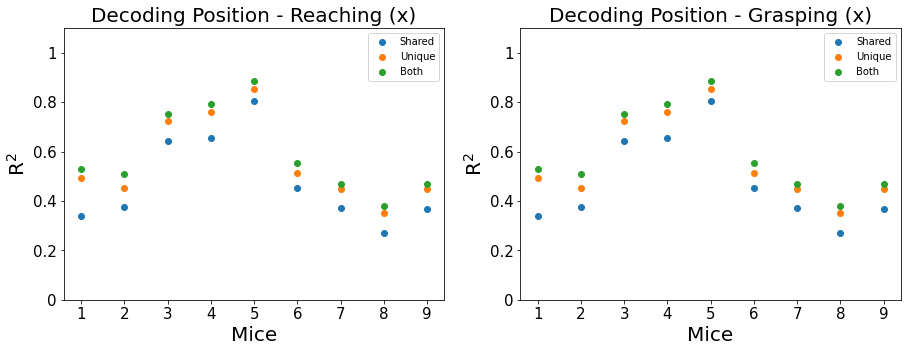

In [49]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[:8,'Shared - Reach']))
ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[:8,'Unique - Reach ']))
ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[:8,'Both - Reach ']))

ax[0].set_xlabel('Mice',fontsize=20)
ax[0].set_ylabel('R$^2$',fontsize=20)
ax[0].set_ylim(0,1.1)

ax[0].set_xticks([1,2,3,4,5,6,7,8,9])
ax[0].set_xticklabels([1,2,3,4,5,6,7,8,9],fontsize=15)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])
ax[0].set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=15)

ax[0].set_title('Decoding Position - Reaching (x)',fontsize=20)
ax[0].legend(['Shared','Unique', 'Both'],fontsize=10)



ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[:8,'Shared - Grasp']))
ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[:8,'Unique - Grasp']))
ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[:8,'Both - Grasp']))

ax[1].set_xlabel('Mice',fontsize=20)
ax[1].set_ylabel('R$^2$',fontsize=20)
ax[1].set_ylim(0,1.1)

ax[1].set_xticks([1,2,3,4,5,6,7,8,9])
ax[1].set_xticklabels([1,2,3,4,5,6,7,8,9],fontsize=15)
ax[1].set_yticks([0,0.2,0.4,0.6,0.8,1])
ax[1].set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=15)

ax[1].set_title('Decoding Position - Grasping (x)',fontsize=20)
ax[1].legend(['Shared','Unique', 'Both'],fontsize=10)






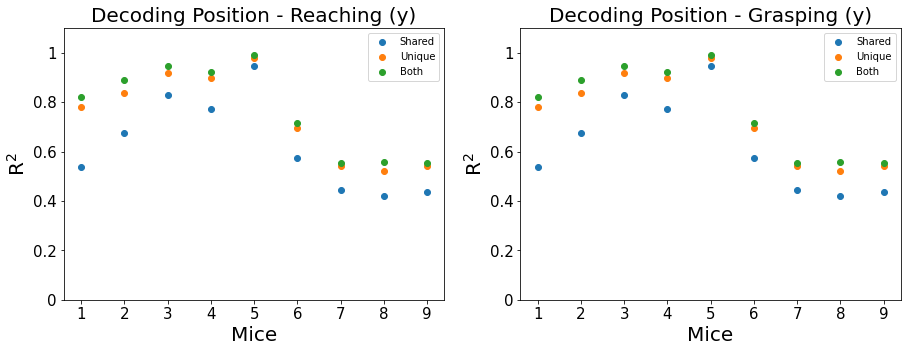

In [53]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[9:17,'Shared - Reach']))
ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[9:17,'Unique - Reach ']))
ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[9:17,'Both - Reach ']))

ax[0].set_xlabel('Mice',fontsize=20)
ax[0].set_ylabel('R$^2$',fontsize=20)
ax[0].set_ylim(0,1.1)

ax[0].set_xticks([1,2,3,4,5,6,7,8,9])
ax[0].set_xticklabels([1,2,3,4,5,6,7,8,9],fontsize=15)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])
ax[0].set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=15)

ax[0].set_title('Decoding Position - Reaching (y)',fontsize=20)
ax[0].legend(['Shared','Unique', 'Both'],fontsize=10)



ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[9:17,'Shared - Grasp']))
ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[9:17,'Unique - Grasp']))
ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[9:17,'Both - Grasp']))

ax[1].set_xlabel('Mice',fontsize=20)
ax[1].set_ylabel('R$^2$',fontsize=20)
ax[1].set_ylim(0,1.1)

ax[1].set_xticks([1,2,3,4,5,6,7,8,9])
ax[1].set_xticklabels([1,2,3,4,5,6,7,8,9],fontsize=15)
ax[1].set_yticks([0,0.2,0.4,0.6,0.8,1])
ax[1].set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=15)

ax[1].set_title('Decoding Position - Grasping (y)',fontsize=20)
ax[1].legend(['Shared','Unique', 'Both'],fontsize=10)






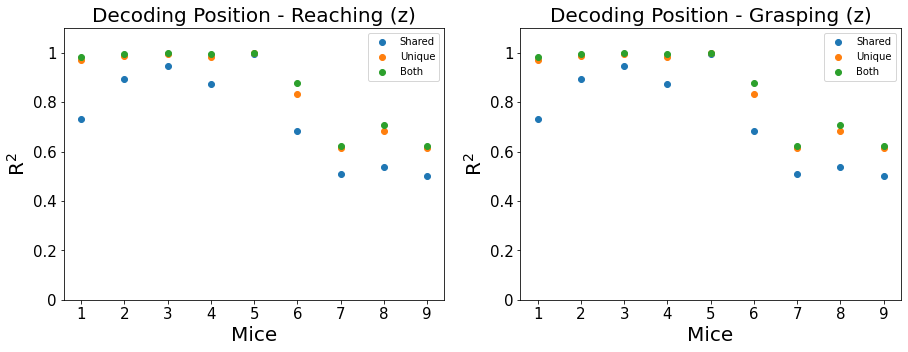

In [54]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[18:,'Shared - Reach']))
ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[18:,'Unique - Reach ']))
ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[18:,'Both - Reach ']))

ax[0].set_xlabel('Mice',fontsize=20)
ax[0].set_ylabel('R$^2$',fontsize=20)
ax[0].set_ylim(0,1.1)

ax[0].set_xticks([1,2,3,4,5,6,7,8,9])
ax[0].set_xticklabels([1,2,3,4,5,6,7,8,9],fontsize=15)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])
ax[0].set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=15)

ax[0].set_title('Decoding Position - Reaching (z)',fontsize=20)
ax[0].legend(['Shared','Unique', 'Both'],fontsize=10)



ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[18:,'Shared - Grasp']))
ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[18:,'Unique - Grasp']))
ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[18:,'Both - Grasp']))

ax[1].set_xlabel('Mice',fontsize=20)
ax[1].set_ylabel('R$^2$',fontsize=20)
ax[1].set_ylim(0,1.1)

ax[1].set_xticks([1,2,3,4,5,6,7,8,9])
ax[1].set_xticklabels([1,2,3,4,5,6,7,8,9],fontsize=15)
ax[1].set_yticks([0,0.2,0.4,0.6,0.8,1])
ax[1].set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=15)

ax[1].set_title('Decoding Position - Grasping (z)',fontsize=20)
ax[1].legend(['Shared','Unique', 'Both'],fontsize=10)

